## Dota 2 Centrality Measures
This notebook contains a 2-by-2 matrix of line charts (similar to Figure 4, not present in the paper) and Spearman's R correlations (similar to Table 4, also not present in the paper), as well as other metrics (graph diameter, sparsity, cyclic-ness, weakly and strongly connected components, etc.)

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

import con_score

Load game data

In [3]:
df1 = pd.read_csv('../output/DOTA2/processed/dota2_final_09-24.csv')
df2 = pd.read_csv('../output/DOTA2/processed/dota2_final_10-24.csv')
df = pd.concat([df1, df2], axis=0)
df = df.dropna(subset=['radiant.name', 'dire.name'])

Create network

In [4]:
G = nx.DiGraph()
for _, row in df.iterrows():
    radiant_team = row['radiant_team_id']
    dire_team = row['dire_team_id']
    if row['radiant_win']:  # Radiant team won
        if G.has_edge(radiant_team, dire_team):
            G[radiant_team][dire_team]['weight'] += 1
        else:
            G.add_edge(radiant_team, dire_team, weight=1)
    else:  # Dire team won
        if G.has_edge(dire_team, radiant_team):
            G[dire_team][radiant_team]['weight'] += 1
        else:
            G.add_edge(dire_team, radiant_team, weight=1)

In [5]:
G.number_of_nodes(), G.number_of_edges()    

(401, 1303)

In [6]:
n = G.number_of_nodes()
m = G.number_of_edges()
sparsity = m / (n * (n - 1))
sparsity

0.008123441396508729

In [ ]:
print(nx.number_weakly_connected_components(G))
print(nx.number_strongly_connected_components(G))

39
199


In [8]:
max_diameter = 0
for component in nx.weakly_connected_components(G):
    subgraph = G.subgraph(component)
    undirected_subgraph = subgraph.to_undirected()
    diameter = nx.diameter(undirected_subgraph)
    max_diameter = max(max_diameter, diameter)
print(f"Maximum Diameter of Weakly Connected Components (Undirected): {max_diameter}")

Maximum Diameter of Weakly Connected Components (Undirected): 10


Compute Centrality Measures

In [ ]:
try:
    CON_score = pd.read_pickle('../output/DOTA2/CON_score.pkl')
except:
    CON_score = con_score.compute_con_scores(G)

In [10]:
#import pickle
#with open('../output/DOTA2/CON_score.pkl', 'wb') as f:
#    pickle.dump(CON_score, f)

In [11]:
G_inverted = G.reverse(copy=True)
pagerank = nx.pagerank(G_inverted, weight='weight')

In [12]:
team_id_to_name = {}
for _, row in df.iterrows():
    team_id_to_name[row['radiant_team_id']] = row['radiant.name']
    team_id_to_name[row['dire_team_id']] = row['dire.name']

In [13]:
rank_data = []
for team in CON_score.keys():
    rank_data.append({'Team Name': team_id_to_name[team], 'Team ID': team, 'CON Score': CON_score[team], 'PageRank': pagerank.get(team, 0)})#, 'Elo': elo_dict.get(team, 0)})
rank_df = pd.DataFrame(rank_data)

In [14]:
team_names = df['radiant.name'].unique().tolist()
team_names.extend(df['dire.name'].unique().tolist())
team_names = list(set(team_names))

Load and merge global rankings

In [15]:
all_elos = pd.read_pickle('../output/DOTA2/processed/all_elos_09-24.pkl')

In [16]:
rank_df['Elo'] = rank_df['Team ID'].apply(lambda x: all_elos.get(x, 0))

In [18]:
rank_df = rank_df[rank_df.Elo != 0]

In [19]:
rank_df.sort_values('CON Score', ascending=False).head(15)

,Team Name,Team ID,CON Score,PageRank,Elo
56,Swift Knights,8629324.0,503,0.003853,995.102
10,Shadow Avengers,9425660.0,498,0.003961,1120.010
6,Flawless Goblins,8629005.0,482,0.004196,952.344
5,Foxy gaming,2443375.0,474,0.003846,946.097
11,Dragon Blood,8629014.0,469,0.003668,1053.590
4,Bright Crusaders,8629317.0,463,0.003690,1017.730
18,Mad Monkeys,8629318.0,446,0.003855,997.211
7,Wiser Warriors,8629315.0,432,0.003402,968.301
69,LSG,9425656.0,420,0.003131,981.809
19,Dark Rebellion,9426115.0,411,0.003297,913.665


In [20]:
out_degree_centrality = dict(G.out_degree(weight='weight'))
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, weight='weight', normalized=True)

centrality_df = pd.DataFrame({
    'Team ID': list(G.nodes),
    'Out-Degree Centrality': [out_degree_centrality.get(player, 0) for player in G.nodes],
    'Closeness Centrality': [closeness_centrality.get(player, 0) for player in G.nodes],
    'Betweenness Centrality': [betweenness_centrality.get(player, 0) for player in G.nodes]
})

### Spearman's Rho & Correlation Coefficients

In [21]:
centrality_df = rank_df.merge(centrality_df, on='Team ID', how='inner')#.sort_values('CON Score', ascending=False).head(15)

In [22]:
centrality_df.shape

(329, 8)

In [ ]:
spearman_out_degree = spearmanr(centrality_df['Elo'], centrality_df['Out-Degree Centrality'], nan_policy='omit')
spearman_closeness = spearmanr(centrality_df['Elo'], centrality_df['Closeness Centrality'], nan_policy='omit')
spearman_betweenness = spearmanr(centrality_df['Elo'], centrality_df['Betweenness Centrality'], nan_policy='omit')
spearman_pagerank = spearmanr(centrality_df['Elo'], centrality_df['PageRank'], nan_policy='omit')
spearman_conscore = spearmanr(centrality_df['Elo'], centrality_df['CON Score'], nan_policy='omit')

results = {
    'Centrality Metric': [
        'Out-Degree Centrality',
        'Closeness Centrality',
        'Betweenness Centrality',
        'PageRank Centrality',
        'CON Score'
    ],
    'Spearmans R Statistic': [
        spearman_out_degree.correlation,
        spearman_closeness.correlation,
        spearman_betweenness.correlation,
        spearman_pagerank.correlation,
        spearman_conscore.correlation
    ],
    'P-Value': [
        spearman_out_degree.pvalue,
        spearman_closeness.pvalue,
        spearman_betweenness.pvalue,
        spearman_pagerank.pvalue,
        spearman_conscore.pvalue
    ]
}

spearman_df = pd.DataFrame(results)
spearman_df.sort_values('Spearmans R Statistic', ascending=False)

,Centrality Metric,Spearmans R Statistic,P-Value
3,PageRank Centrality,0.565837,3.063182e-29
0,Out-Degree Centrality,0.490988,2.302962e-21
4,CON Score,0.383744,5.515046e-13
2,Betweenness Centrality,0.304093,1.816714e-08
1,Closeness Centrality,0.042206,4.454790e-01


In [24]:
spearman_df.to_csv('../output/DOTA2/dota2_centrality_correlation_table.csv', index=False)

In [25]:
centrality_df.to_csv('../output/DOTA2/processed/dota2_team_rankings.csv', index=False)

Unity Normalization of Centralities

In [26]:
for col in ['Out-Degree Centrality',  'Betweenness Centrality', 'PageRank', 'CON Score', 'Elo']:
    centrality_df[col] = (centrality_df[col] - centrality_df[col].min()) / (centrality_df[col].max() - centrality_df[col].min())

In [27]:
centrality_df['Team ID'] = centrality_df['Team ID'].astype(str)

In [28]:
centrality_df['Team ID'].nunique()

329

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


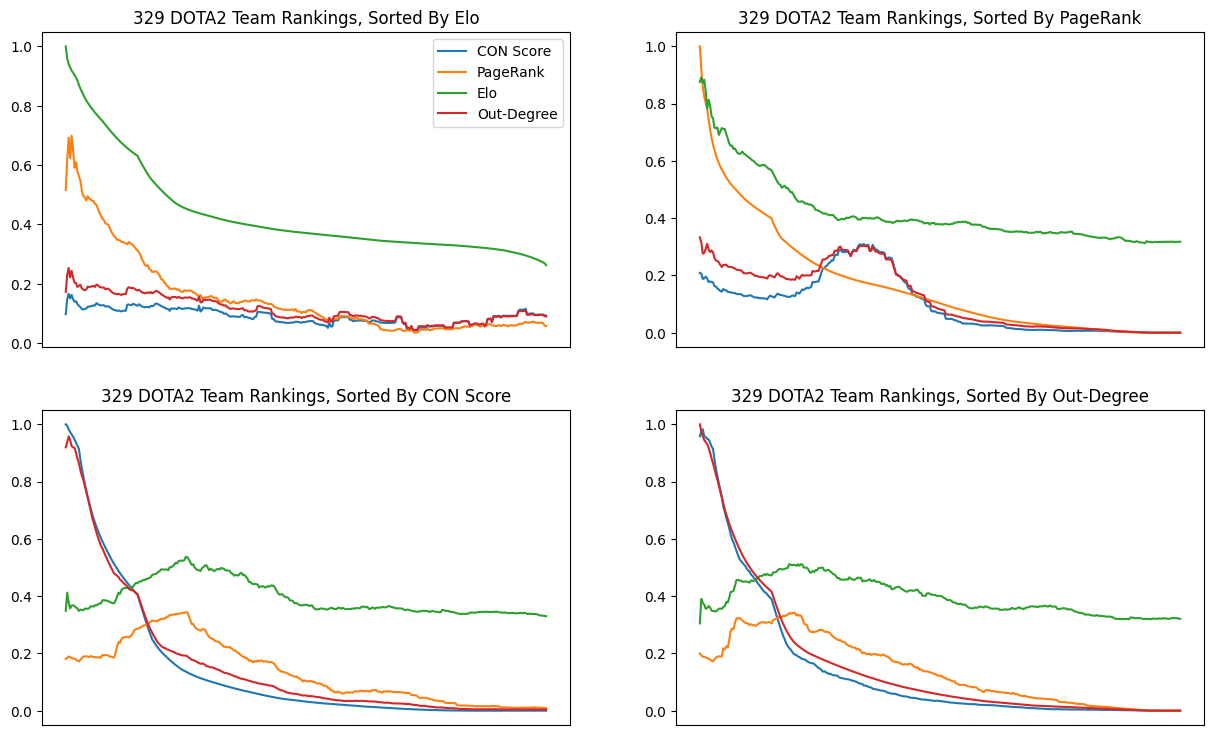

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15,9))

window_size = 50  
def smooth_series(data, window):
    return data.rolling(window=window, min_periods=1).mean()

centrality_df_small = centrality_df.sort_values('Elo', ascending=False)#.head(n)
axs[0, 0].plot(centrality_df_small['Team ID'], smooth_series(centrality_df_small['CON Score'], window_size), label='CON Score')
axs[0, 0].plot(centrality_df_small['Team ID'], smooth_series(centrality_df_small['PageRank'], window_size), label='PageRank')
axs[0, 0].plot(centrality_df_small['Team ID'], smooth_series(centrality_df_small['Elo'], window_size), label='Elo')
axs[0, 0].plot(centrality_df_small['Team ID'], smooth_series(centrality_df_small['Out-Degree Centrality'], window_size), label='Out-Degree')
axs[0, 0].set_title('329 DOTA2 Team Rankings, Sorted By Elo')
axs[0, 0].legend()
axs[0, 0].set_xticks([])

centrality_df_small = centrality_df.sort_values('PageRank', ascending=False)#.head(n)
axs[0, 1].plot(centrality_df_small['Team ID'], smooth_series(centrality_df_small['CON Score'], window_size), label='CON Score')
axs[0, 1].plot(centrality_df_small['Team ID'], smooth_series(centrality_df_small['PageRank'], window_size), label='PageRank')
axs[0, 1].plot(centrality_df_small['Team ID'], smooth_series(centrality_df_small['Elo'], window_size), label='Elo')
axs[0, 1].plot(centrality_df_small['Team ID'], smooth_series(centrality_df_small['Out-Degree Centrality'], window_size), label='Out-Degree')
axs[0, 1].set_title('329 DOTA2 Team Rankings, Sorted By PageRank')
axs[0, 1].set_xticks([])

centrality_df_small = centrality_df.sort_values('CON Score', ascending=False)#.head(n)
axs[1, 0].plot(centrality_df_small['Team ID'], smooth_series(centrality_df_small['CON Score'], window_size), label='CON Score')
axs[1, 0].plot(centrality_df_small['Team ID'], smooth_series(centrality_df_small['PageRank'], window_size), label='PageRank')
axs[1, 0].plot(centrality_df_small['Team ID'], smooth_series(centrality_df_small['Elo'], window_size), label='Elo')
axs[1, 0].plot(centrality_df_small['Team ID'], smooth_series(centrality_df_small['Out-Degree Centrality'], window_size), label='Out-Degree')
axs[1, 0].set_title('329 DOTA2 Team Rankings, Sorted By CON Score')
axs[1, 0].set_xticks([])

centrality_df_small = centrality_df.sort_values('Out-Degree Centrality', ascending=False)#.head(n)
axs[1, 1].plot(centrality_df_small['Team ID'], smooth_series(centrality_df_small['CON Score'], window_size), label='CON Score')
axs[1, 1].plot(centrality_df_small['Team ID'], smooth_series(centrality_df_small['PageRank'], window_size), label='PageRank')
axs[1, 1].plot(centrality_df_small['Team ID'], smooth_series(centrality_df_small['Elo'], window_size), label='Elo')
axs[1, 1].plot(centrality_df_small['Team ID'], smooth_series(centrality_df_small['Out-Degree Centrality'], window_size), label='Out-Degree')
axs[1, 1].set_title('329 DOTA2 Team Rankings, Sorted By Out-Degree')
axs[1, 1].set_xticks([])

plt.savefig('../output/DOTA2/DOTA_centrality_measures_MA_2x2_plot.eps', format='eps')
plt.show()